In [ ]:
The Cancer Genome Atlas (TCGA)
Pan-Cancer analysis project investigators.

In [1]:
import tarfile
import urllib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [8]:
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"
# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)
# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)
# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

Now, get the data and the true labels

In [11]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

data = np.genfromtxt(
datafile,
delimiter=",",
usecols=range(1, 20532),
skip_header=1)

true_label_names = np.genfromtxt(
labels_file,
delimiter=",",
usecols=(1,),
skip_header=1,
dtype="str")

In [14]:
print(data.shape)

(801, 20531)


801 samples have information for 20531 genes

In [18]:
print(true_label_names.shape)

(801,)


BRCA: Breast invasive carcinoma
COAD: Colon adenocarcinoma
KIRC: Kidney renal clear cell carcinoma
LUAD: Lung adenocarcinoma
PRAD: Prostate adenocarcinoma

Let's convert labels to integers with LabelEncoder()

In [20]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(true_label_names)
true_labels[:5]

array([4, 3, 4, 4, 0])

In [21]:
label_encoder.classes_ # labels that have been encoded

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype='<U4')

And let's get the number of clusters

In [22]:
n_clusters = len(label_encoder.classes_)

## Dimensionality reduction
To avoid the curse of dimensionality

We create a preprocessing pipeline with MinMaxScaler and PCA

In [23]:
preprocessor = Pipeline(
[
("scaler", MinMaxScaler()),
("pca", PCA(n_components=2, random_state=42)),
])

Now, we build the clustering pipeline

In [24]:
clusterer = Pipeline(
[
(
    "kmeans",
    KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        n_init=50,
        max_iter=500,
        random_state=42,
    ),
),
]
)

Now, we join the two components


In [31]:
pipe = Pipeline(
[
    ("preprocessor", preprocessor),
    ("clusterer", clusterer)
]
)

In [32]:
pipe.fit(data)

Pipeline(memory=None,
     steps=[('preprocessor', Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False))])), ('clusterer', Pipeline(memory=None,
     steps=[('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
    n_clusters=5, n_init=50, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0))]))])

Evaluate the performance by calculating the silhouette coefficient:

In [44]:
preprocessed_data = pipe.named_steps['preprocessor'].transform(data)
predicted_labels = pipe.named_steps["clusterer"].named_steps["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)

0.5118775528450293

Calculate ARI, too, since the ground truth cluster labels are available:

In [45]:
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

An ARI score of 0 indicates that cluster labels are randomly assigned, and an ARI score of 1 means that the true labels and predicted labels form identical clusters.

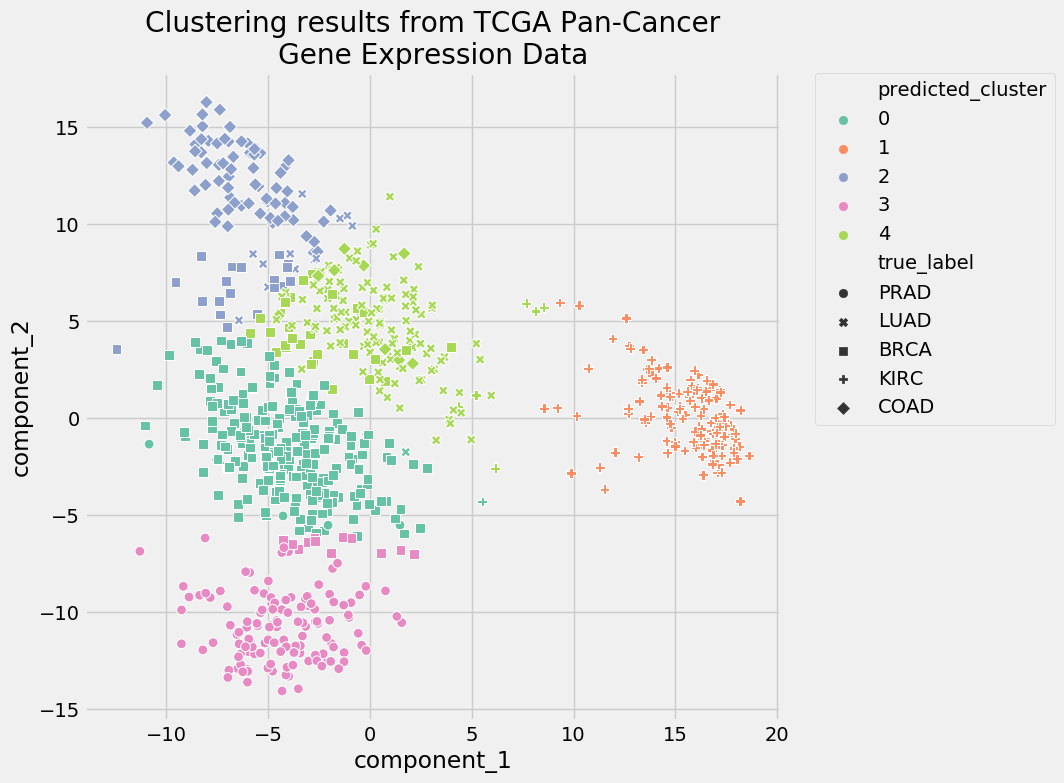

In [47]:
pcadf = pd.DataFrame(
     pipe.named_steps["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe.named_steps["clusterer"].named_steps["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

Tuning a K-Means Clustering Pipeline
The process of parameter tuning consists of sequentially altering one of the input values of the algorithm’s parameters and recording the results. At the end of the parameter tuning process, you’ll have a set of performance scores, one for each new value of a given parameter. Parameter tuning is a powerful method to maximize performance from your clustering pipeline.

By setting the PCA parameter n_components=2, you squished all the features into two components, or dimensions. This value was convenient for visualization on a two-dimensional plot. But using only two components means that the PCA step won’t capture all of the explained variance of the input data.

In this example, you’ll use clustering performance metrics to identify the appropriate number of components in the PCA step. The Pipeline class is powerful in this situation. It allows you to perform basic parameter tuning using a for loop.

Iterate over a range of n_components and record evaluation metrics for each iteration:

In [53]:
# Empty lists to hold evaluation metrics
silhouette_scores = []
ari_scores = []
for n in range(2, 11):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe.named_steps["preprocessor"].named_steps["pca"].n_components = n
    pipe.fit(data)

    silhouette_coef = silhouette_score(
    pipe.named_steps["preprocessor"].transform(data),
    pipe.named_steps["clusterer"].named_steps["kmeans"].labels_,
    )
    ari = adjusted_rand_score(
    true_labels,
    pipe.named_steps["clusterer"].named_steps["kmeans"].labels_,
    )
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)

Plot the evaluation metrics as a function of n_components to visualize the relationship between adding components and the performance of the k-means clustering results:

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
    range(2, 11),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
plt.plot(range(2, 11), ari_scores, c="#fc4f30", label="ARI")

plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a Function of n_components")
plt.tight_layout()
plt.show()